In [1]:
%matplotlib inline
%load_ext line_profiler
from __future__ import print_function, division

from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, ReflectivityFitFunction, CurveFitter, to_parameters
import refnx.analysis.reflect as reflect

import corner
from lmfit.printfuncs import fit_report
import numpy as np
from matplotlib.pyplot import *

In [2]:
DATASET_NAME = 'c_PLP0011859_q.txt'
USE_DIFFERENTIAL_EVOLUTION = True

In [3]:
#load the data
dataset = ReflectDataset(DATASET_NAME)

xdata, ydata, dydata, dxdata = dataset.data

In [4]:
# These arrays described the layered nature of the system.
layers = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [30,  3.47, 0, 3],     # 1st layer
                   [250, 2.00, 0, 3],     # 2nd layer
                   [0,   6.36, 0, 3]])     # backing medium

varies = np.array([[False, False, False, False],     # fronting medium
                   [True, False, False, True],     # 1st layer
                   [True, True, False, True],     # 2nd layer
                   [False, False, False, True]])     # backing medium

lowlim = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [15,  3.47, 0, 1],     # 1st layer
                   [200, 0.10, 0, 1],     # 2nd layer
                   [0,   6.36, 0, 1]])     # backing medium

hilim = np.array([[0,   2.07, 0, 0],     # fronting medium
                  [50,  3.47, 0, 9],     # 1st layer
                  [300, 3.00, 0, 9],     # 2nd layer
                  [0,   6.36, 0, 15]])     # backing medium

In [5]:
# But we need these parameters in a 1D array. convert_layer_format_to_coefs does this.
coefs = reflect.layer_to_coefs(layers, scale=1, bkg=3e-6)
varies = np.asarray(reflect.layer_to_coefs(varies, scale=True, bkg=True), bool)
lowlim = reflect.layer_to_coefs(lowlim, scale=0.6, bkg=0)
hilim = reflect.layer_to_coefs(hilim, scale=1.2, bkg=9e-6)

bounds = zip(lowlim, hilim)

In [6]:
# create a parameter instance
parameters = to_parameters(coefs,
                           names=ReflectivityFitFunction.parameter_names(len(coefs)),
                           bounds=bounds,
                           varies=varies)

In [7]:
# use resolution smearing and fit on a logR scale (transform the data as well)
t = Transform('logY').transform
ydata, dydata = t(xdata, ydata, dydata)
fcn_kws = {'transform': t, 'parallel': True, 'dqvals': dxdata}

In [8]:
# create the fit instance
RFF = ReflectivityFitFunction(transform=t)
fitter = CurveFitter(RFF,
                     xdata,
                     ydata,
                     parameters,
                     edata=dydata,
                     fcn_kws=fcn_kws)

#do the fit
method = 'leastsq'
if USE_DIFFERENTIAL_EVOLUTION:
    method='differential_evolution'

%time res = fitter.fit(method)

CPU times: user 11.9 s, sys: 361 ms, total: 12.3 s
Wall time: 12.2 s


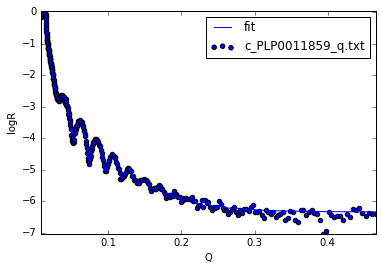

In [9]:
scatter(xdata, ydata, label=DATASET_NAME)
plot(xdata, RFF.model(xdata, res.params, dqvals=dxdata), label='fit')
ylim(min(np.min(ydata), np.min(fitter.model(res.params))),
     max(np.max(ydata), np.max(fitter.model(res.params))))
xlim(np.min(xdata), np.max(xdata))
xlabel('Q')
ylabel('logR')
legend()

c_PLP0011859_q.txt
[[Variables]]
    nlayers:      2 (fixed)
    scale:        0.87939519 (init= 1)
    SLDfront:     2.07 (fixed)
    iSLDfront:    0 (fixed)
    SLDback:      6.36 (fixed)
    iSLDback:     0 (fixed)
    bkg:          4.5877e-07 (init= 3e-06)
    sigma_back:   3.78809860 (init= 3)
    thick1:       38.6400902 (init= 30)
    SLD1:         3.47 (fixed)
    iSLD1:        0 (fixed)
    sigma1:       5.84341713 (init= 3)
    thick2:       259.039801 (init= 250)
    SLD2:         2.40200545 (init= 2)
    iSLD2:        0 (fixed)
    sigma2:       8.82434864 (init= 3)
[[Correlations]] (unreported correlations are <  0.100)


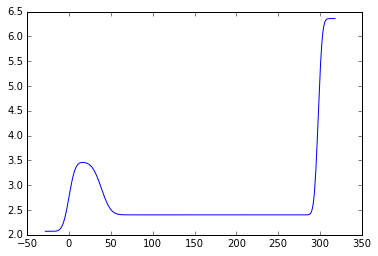

In [10]:
z, rho_z = RFF.sld_profile(res.params)
plot(z, rho_z)

print(DATASET_NAME)
print(fit_report(res.params))

In [11]:
%time res_emcee = fitter.emcee(res.params, steps=1000, burn=300, thin=10, workers=4)

CPU times: user 37.7 s, sys: 739 ms, total: 38.4 s
Wall time: 1min 40s


In [12]:
print(fit_report(res_emcee))

[[Fit Statistics]]
    # function evals   = 0
    # data points      = unknown
    # variables        = 8
    chi-square         = unknown
    reduced chi-square = unknown
[[Variables]]
    nlayers:      2 (fixed)
    scale:        0.87991370 +/- 0.003058 (0.35%) (init= 0.8793952)
    SLDfront:     2.07 (fixed)
    iSLDfront:    0 (fixed)
    SLDback:      6.36 (fixed)
    iSLDback:     0 (fixed)
    bkg:          4.5743e-07 +/- 2.21e-08 (4.84%) (init= 4.587748e-07)
    sigma_back:   3.77147479 +/- 0.114818 (3.04%) (init= 3.788099)
    thick1:       38.6681572 +/- 0.352162 (0.91%) (init= 38.64009)
    SLD1:         3.47 (fixed)
    iSLD1:        0 (fixed)
    sigma1:       5.85662274 +/- 0.302784 (5.17%) (init= 5.843417)
    thick2:       259.040136 +/- 0.238633 (0.09%) (init= 259.0398)
    SLD2:         2.40571754 +/- 0.011527 (0.48%) (init= 2.402005)
    iSLD2:        0 (fixed)
    sigma2:       8.68485952 +/- 0.247908 (2.85%) (init= 8.824349)
[[Correlations]] (unreported correlation

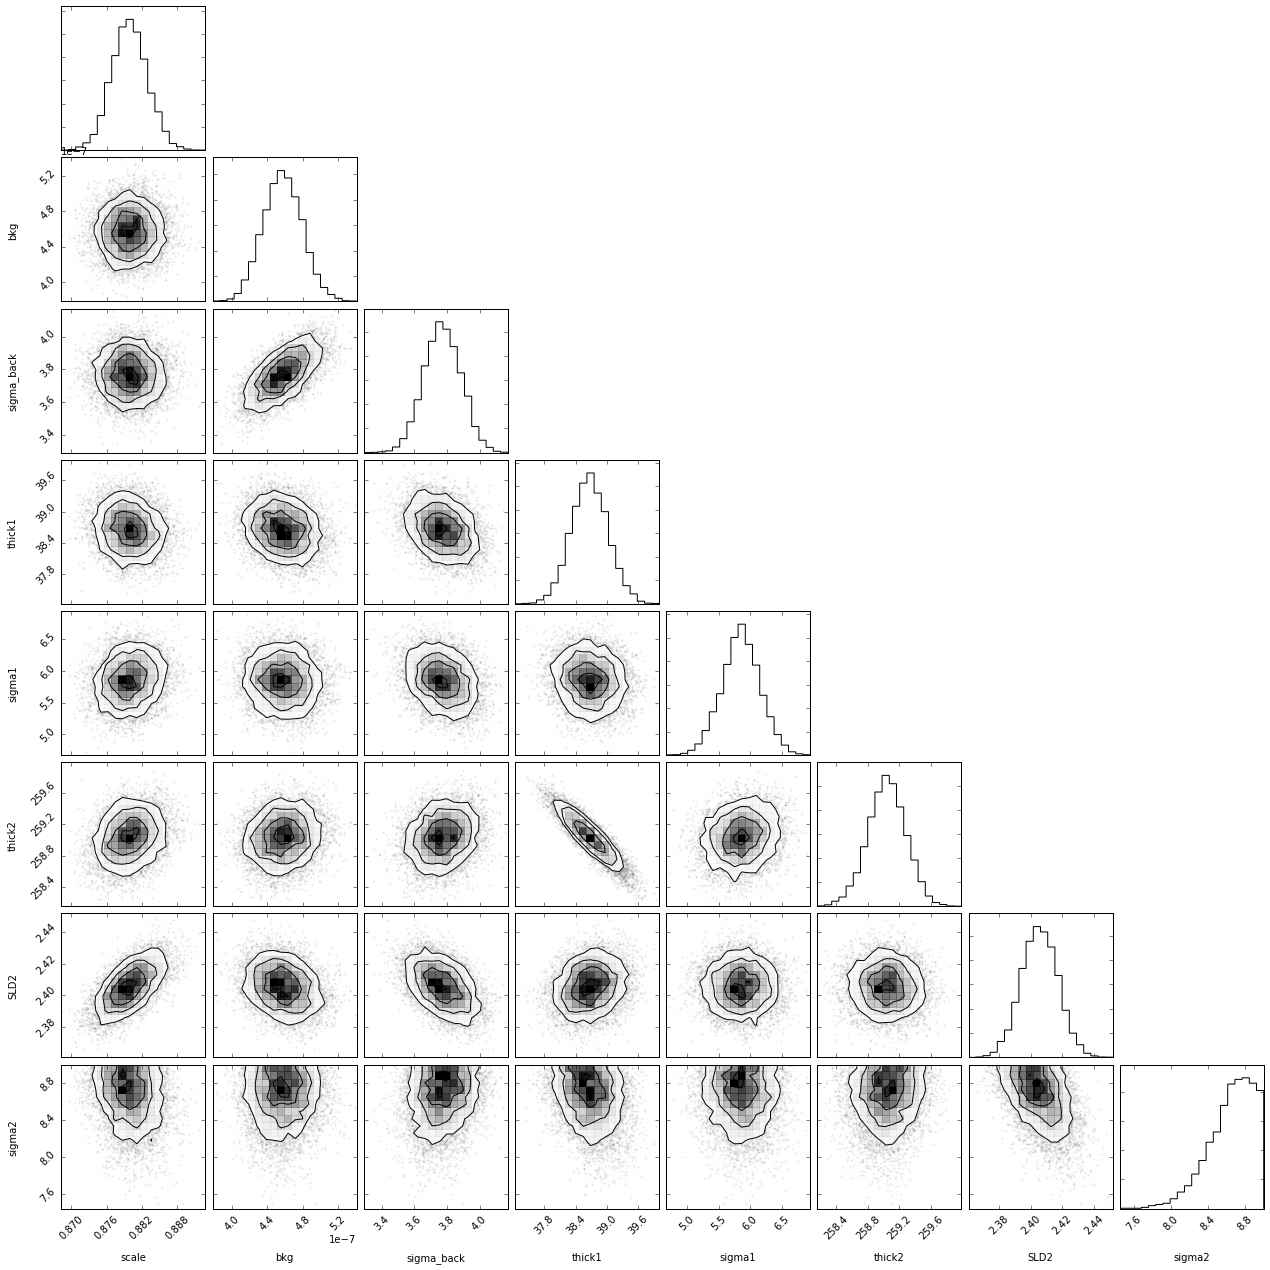

In [13]:
a = corner.corner(res_emcee.flatchain)

In [14]:
def pgen(parameters, flatchain, idx=None):
    # generator for all the different parameters from a flatchain.
    if idx is None:
        idx = range(np.size(flatchain, 0))
    for i in idx:
        vec = flatchain.iloc[i]
        for var_name in flatchain.columns:
            parameters[var_name].value = flatchain.iloc[i][var_name]
        yield parameters

(0.0080602199999999999, 0.465555)

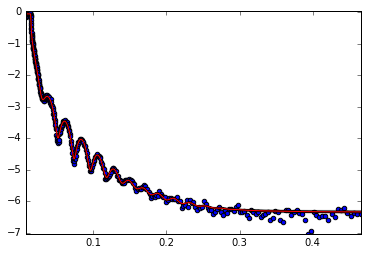

In [15]:
scatter(xdata, ydata)
for par in pgen(parameters, res_emcee.flatchain, idx=np.random.randint(len(res_emcee.flatchain), size=500)):
    plot(xdata, fitter.model(par), color="k", alpha=0.01)
plot(xdata, RFF.model(xdata, res_emcee.params), color='r')

ylim(np.min(ydata), np.max(ydata))
xlim(np.min(xdata), np.max(xdata))

(2.2, 6)

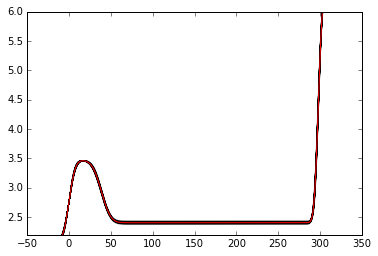

In [16]:
z, true_sld = RFF.sld_profile(res_emcee.params)
for par in pgen(parameters, res_emcee.flatchain, idx=np.random.randint(len(res_emcee.flatchain), size=500)):
    plot(z, RFF.sld_profile(par, points=z)[1], color='k', alpha =0.05)
    
plot(z, true_sld, lw=1, color='r')
ylim(2.2, 6)